In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

import sys 
sys.path.append("../")
from KDG import KDG

import seaborn as sns
import warnings

import pickle

from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Using TensorFlow backend.



Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Experiment Parameters

In [2]:
width = 3
n = 50000
acc_thresh = 0.9
epochs = 20

train_new = False

# Data Generation
## Function

In [3]:
def generate_XOR(n):
    '''
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.uniform(low = -1, high = 1, size = (n, 1)) for _ in range(2)], axis = 1)

    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

    return X, y
    '''
    means = np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]])
    X = np.concatenate([np.random.multivariate_normal(mean, 0.25 * np.eye(len(mean)),
                                                 size=int(n / 4)) for mean in means])

    y = np.concatenate([np.ones(int(n / 4)) * int(idx < 2) for idx in range(len(means))])

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

## Training Data

In [4]:
X, y = generate_XOR(n = n)

## Grid Generation

In [5]:
x_min, x_max = -4, 4
y_min, y_max = -4, 4
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min) / 100),
                      np.arange(y_min, y_max, (y_max - y_min) / 100))

# Construct & Train Network

In [6]:
def get_network():
    network = keras.Sequential()
    network.add(keras.layers.Dense(width + 1, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=True, kernel_initializer = 'he_normal'))
    network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=True, kernel_initializer = 'he_normal'))
    network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(1e-2, momentum = 0.9), metrics = ['acc'])
    return network

In [7]:
if train_new:
    acc = 0
    while acc < acc_thresh:
      network = get_network()
      network.fit(
          X, 
          y, 
          epochs = epochs, 
          verbose = True,
          batch_size = 256
      )

      acc = network.evaluate(X, y, verbose = False)[1]
      if acc >= acc_thresh:
        print("Done training. Acc = {:0.2f} > Acc Thresh = {:0.2f}.".format(acc, acc_thresh))
      else:
        print("Training New Network since Acc = {:0.2f} < Acc Thresh = {:0.2f}...".format(acc, acc_thresh))
      network.save_weights("best_weights.h5")
else:
    network = get_network()
    network.load_weights("best_weights.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Polytope Pyramid

In [8]:
input_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1}]
input_bias, ultimate_bias = [network.layers[i].get_weights()[1] for i in {0, 1}]

second_layer_preactivations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights) + input_bias 
second_layer_binary_activations = (second_layer_preactivations > 0).astype('int')
second_layer_activations = second_layer_preactivations * second_layer_binary_activations

ultimate_preactivations = np.matmul(second_layer_activations, ultimate_weights) + ultimate_bias
ultimate_binary_activations = (ultimate_preactivations > 0).astype('int')
ultimate_activations = ultimate_preactivations * ultimate_binary_activations

In [9]:
signed_second_layer_activations = (second_layer_preactivations > 0).astype('int')
signed_ultimate_activations = (ultimate_preactivations > 0).astype('int')

polytope_memberships = np.concatenate([signed_second_layer_activations, signed_ultimate_activations], axis = 1)
unique_polytope_ids, polytope_ids = np.unique(np.matmul(polytope_memberships, 2 ** np.arange(0, np.shape(polytope_memberships)[1])), return_inverse = True)

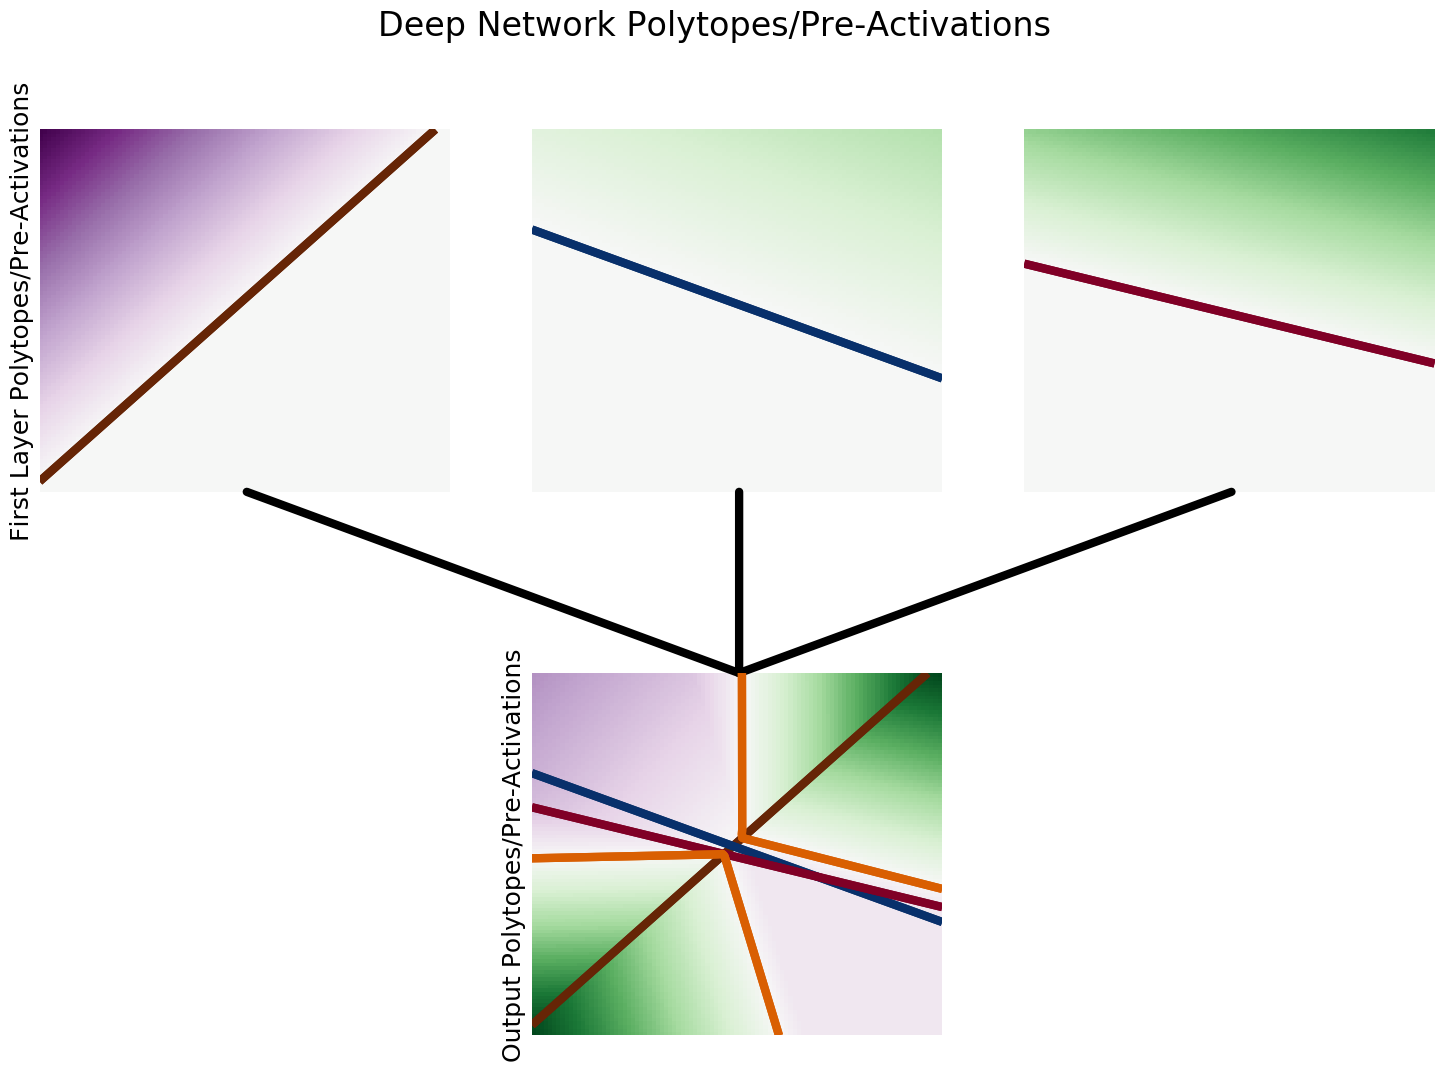

In [17]:
figs, axs = plt.subplots(2, width, figsize = (6 * width, 6 * 2))
plt.subplots_adjust(hspace=0.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')
figs.suptitle("Deep Network Polytopes/Pre-Activations", fontsize = 24)

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
    if i == 0:
        ax.set_ylabel('First Layer Polytopes/Pre-Activations', fontsize = 18)
    if i == 4:
        ax.set_ylabel('Output Polytopes/Pre-Activations', fontsize = 18)
        
for second_node in range(width):
    if second_node == 0:
        cmap = "YlOrBr" 
    elif second_node == 1:
        cmap = "Blues"
    elif second_node == 2:
        cmap = "YlOrRd"
    for multiplier in [-1, 1]:
      axs[0][second_node].contour(xx, 
                                       yy, 
                                       second_layer_preactivations[:, second_node].reshape(xx.shape) + multiplier * 1e-6, 
                                       levels=[0], 
                                       cmap=cmap,
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6
                                    )
    axs[0][second_node].pcolormesh(xx, 
                          yy, 
                          np.sign(ultimate_weights[second_node]) *second_layer_activations[:, second_node].reshape(xx.shape), 
                          cmap="PRGn", 
                          vmin = -np.max(second_layer_activations), 
                          vmax = np.max(second_layer_activations)
                          )

for second_node in range(width):
  second_w_sign = np.sign(ultimate_weights[second_node])
  second_node_contributes = np.abs(ultimate_weights[second_node]) > 1e-6

  if second_node_contributes:
    con = ConnectionPatch(axesA=axs[0][second_node], 
                        axesB=axs[1][int(width / 2)], 
                        xyA = [0, np.min(yy)],
                        xyB = [0, np.max(yy)],
                        coordsA="data", 
                        coordsB="data", 
                        color="black", 
                        lw=6)
    axs[1][int(width / 2)].add_artist(con)

for second_node in range(width):
    if second_node == 0:
        cmap = "YlOrBr" 
    elif second_node == 1:
        cmap = "Blues"
    elif second_node == 2:
        cmap = "YlOrRd"
    for multiplier in [-1, 1]:
      axs[1][int(width / 2)].contour(xx, 
                                       yy, 
                                       second_layer_preactivations[:, second_node].reshape(xx.shape) + multiplier * 1e-6, 
                                       levels=[0], 
                                       cmap=cmap,
                                       vmin = -1, 
                                       vmax = 0,
                                       linewidths = 6
                                    )

axs[1][int(width / 2)].pcolormesh(xx, 
                               yy, 
                               ultimate_preactivations.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = -np.max(np.abs(ultimate_preactivations)), 
                               vmax = np.max(np.abs(ultimate_preactivations)))

for multiplier in [-1, 1]:
  axs[1][int(width / 2)].contour(xx, 
                               yy, 
                               ultimate_preactivations.reshape(xx.shape) + multiplier * 1e-6, 
                               colors="#d95f02", 
                               vmin = -1, 
                               vmax = 0,
                               levels=[0],
                               linewidths=6,
                               zorder = 1e16) 

In [18]:
def pdf(x):
    mu01, mu02, mu11, mu12 = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
    cov = 0.25 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return [p0, p1]

true_posterior = np.array([pdf(x) for x in tqdm(np.c_[xx.ravel(), yy.ravel()])])

100%|██████████| 10000/10000 [00:01<00:00, 9612.87it/s]


In [19]:
if train_new:
    acc = 0
    decision_paths = [[]]
    while True:
      rfc = RandomForestClassifier(n_estimators = 1, 
                                   max_depth = width)

      rfc.fit(X, y)
      y_hat = rfc.predict(X)
      acc = np.mean(y_hat == y) 
      decision_paths = rfc.estimators_[0].decision_path(np.c_[xx.ravel(), yy.ravel()]).toarray()
      data_decision_paths = rfc.estimators_[0].decision_path(X).toarray()
      if acc >= acc_thresh and acc < .97 and np.shape(decision_paths)[1] == 15:
        print("Done training. Acc = {:0.2f} > Acc Thresh = {:0.2f}.".format(acc, acc_thresh))
        break
      else:
        print("Training New Forest since Acc = {:0.2f} < Acc Thresh = {:0.2f}...".format(acc, acc_thresh))
    pickle.dump(rfc, open('best_forest.pkl', 'wb'))
else:
    rfc = pickle.load(open('best_forest.pkl', 'rb'))
    decision_paths = rfc.estimators_[0].decision_path(np.c_[xx.ravel(), yy.ravel()]).toarray()
    data_decision_paths = rfc.estimators_[0].decision_path(X).toarray()

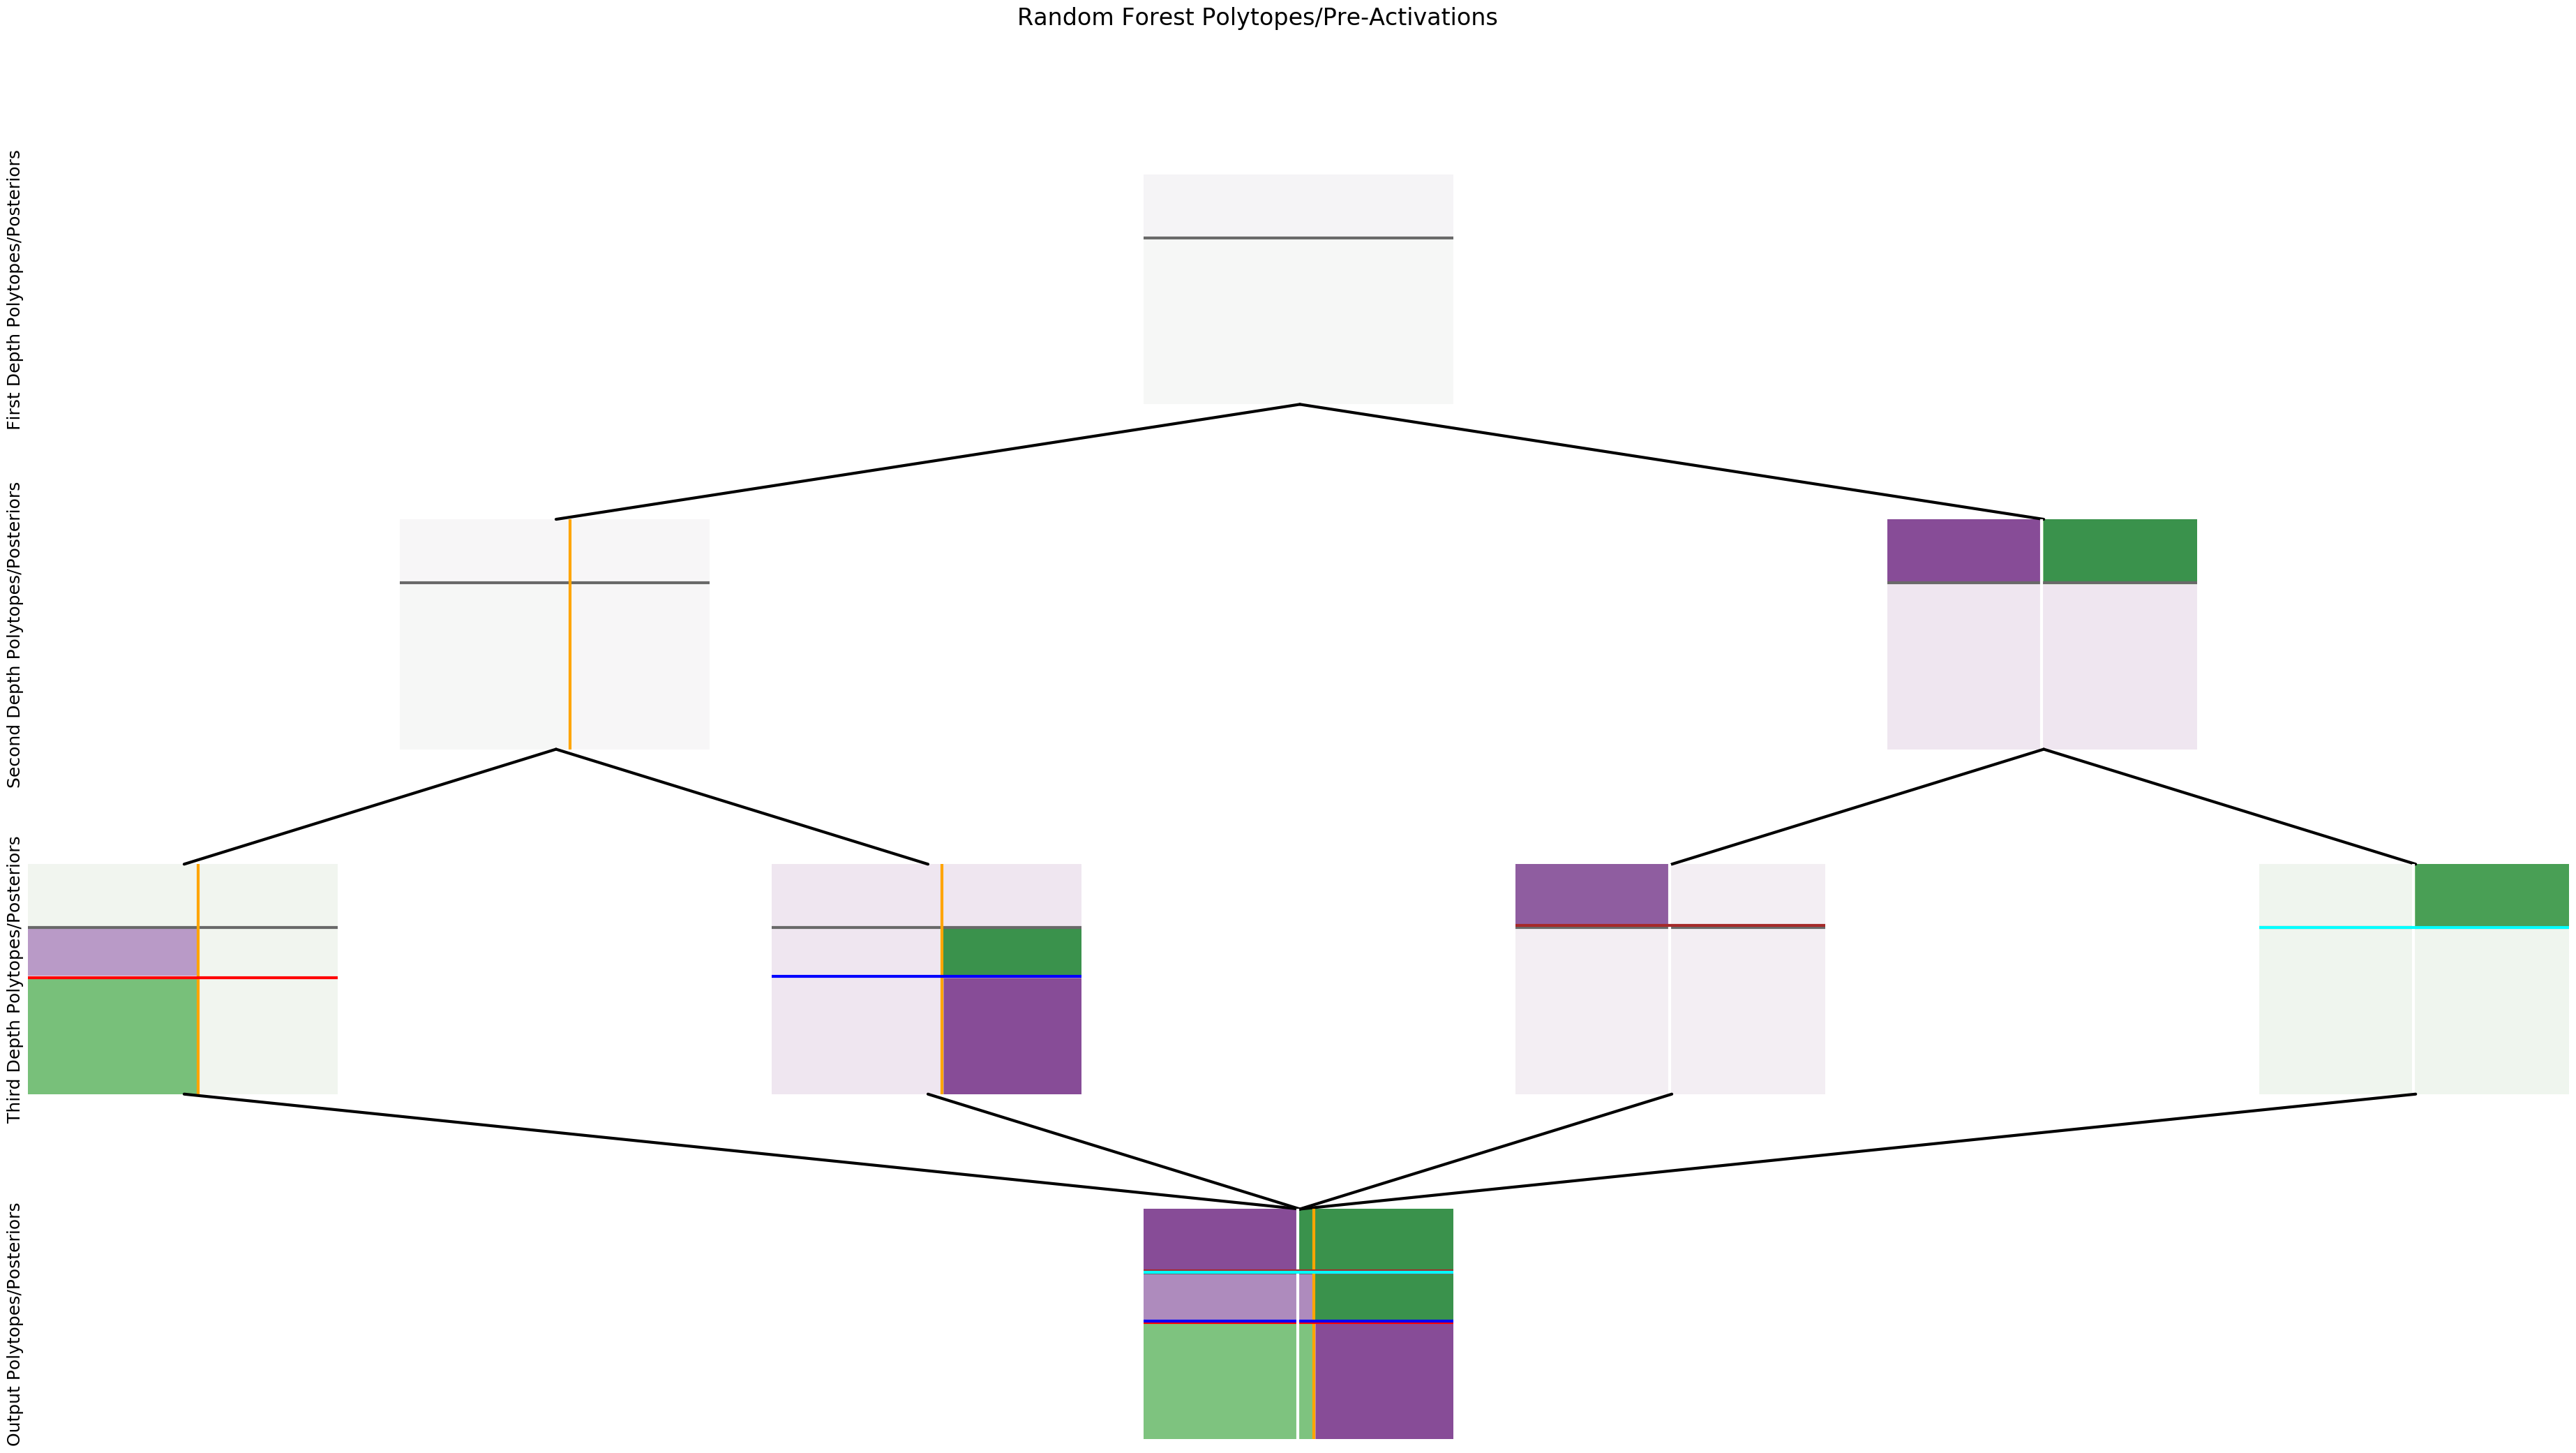

In [24]:
figs, axs = plt.subplots(width + 1, 2 ** (width) - 1, figsize = (6 * 2 ** width - 1, 6 * (width + 1)))
plt.subplots_adjust(hspace=0.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')
figs.suptitle("Random Forest Polytopes/Pre-Activations", fontsize = 24)

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
    if i == 0 * 7:
        ax.set_ylabel('First Depth Polytopes/Posteriors', fontsize = 18)
    if i == 1 * 7:
        ax.set_ylabel('Second Depth Polytopes/Posteriors', fontsize = 18)
    if i == 2 * 7:
        ax.set_ylabel('Third Depth Polytopes/Posteriors', fontsize = 18)
    if i == 3 * 7:
        ax.set_ylabel('Output Polytopes/Posteriors', fontsize = 18)
        
cmap = {0: "dimgray", 1 : "orange", 2 : "red", 5 : "blue", 8 : "white", 9 : "brown", 12 : "aqua"}
        
posterior = np.ones_like(xx.ravel()) * 0.5
for node in [1, 8]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[0][int((2 ** (width) - 1) // 2)].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
for feat in [0]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[0][int((2 ** (width) - 1) // 2)].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[0][int((2 ** (width) - 1) // 2)].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [2, 5]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[1][int((2 ** (width) - 1) // 2) - 2].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[0][int((2 ** (width) - 1) // 2)], 
                    axesB=axs[1][int((2 ** (width) - 1) // 2) - 2], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[1][int((2 ** (width) - 1) // 2) - 2].add_artist(con)
for feat in [0, 1]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[1][int((2 ** (width) - 1) // 2) - 2].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[1][int((2 ** (width) - 1) // 2) - 2].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [9, 12]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[1][int((2 ** (width) - 1) // 2) + 2].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[0][int((2 ** (width) - 1) // 2)], 
                    axesB=axs[1][int((2 ** (width) - 1) // 2) + 2], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[1][int((2 ** (width) - 1) // 2) + 2].add_artist(con)
for feat in [0, 8]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[1][int((2 ** (width) - 1) // 2) + 2].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[1][int((2 ** (width) - 1) // 2) + 2].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [3, 4]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[2][int((2 ** (width) - 1) // 4) - 1].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[1][int((2 ** (width) - 1) // 2) - 2], 
                    axesB=axs[2][int((2 ** (width) - 1) // 4) - 1], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[2][int((2 ** (width) - 1) // 4) - 1].add_artist(con)
for feat in [0, 1, 2]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[2][int((2 ** (width) - 1) // 4) - 1].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[2][int((2 ** (width) - 1) // 4) - 1].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [6, 7]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[2][int((2 ** (width) - 1) // 4) + 1].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[1][int((2 ** (width) - 1) // 2) - 2], 
                    axesB=axs[2][int((2 ** (width) - 1) // 4) + 1], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[2][int((2 ** (width) - 1) // 4) + 1].add_artist(con)
for feat in [0, 1, 5]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[2][int((2 ** (width) - 1) // 4) + 1].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[2][int((2 ** (width) - 1) // 4) + 1].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [10, 11]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[2][int(3 * (2 ** (width) - 1) // 4) - 1].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[1][int((2 ** (width) - 1) // 2) + 2], 
                    axesB=axs[2][int(3 * (2 ** (width) - 1) // 4) - 1], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[2][int(3 * (2 ** (width) - 1) // 4) - 1].add_artist(con)
for feat in [0, 8, 9]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[2][int(3 * (2 ** (width) - 1) // 4) - 1].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[2][int(3 * (2 ** (width) - 1) // 4) - 1].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [13, 14]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[2][int(3 * (2 ** (width) - 1) // 4) + 1].contourf(xx, 
             yy, 
             posterior.reshape(xx.shape), 
             cmap = "PRGn",
             vmin = 0,
             vmax = 1)
con = ConnectionPatch(axesA=axs[1][int((2 ** (width) - 1) // 2) + 2], 
                    axesB=axs[2][int(3 * (2 ** (width) - 1) // 4) + 1], 
                    xyA = [0, np.min(yy)],
                    xyB = [0, np.max(yy)],
                    coordsA="data", 
                    coordsB="data", 
                    color="black",
                    linewidth = 3)
axs[2][int(3 * (2 ** (width) - 1) // 4) + 1].add_artist(con)
for feat in [0, 8, 12]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[2][int(3 * (2 ** (width) - 1) // 4) + 1].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[2][int(3 * (2 ** (width) - 1) // 4) + 1].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

posterior = np.ones_like(xx.ravel()) * 0.5
for node in [3, 4, 6, 7, 10, 11, 13, 14]:
    indices_of_activation = np.where(decision_paths[:, node] == 1)[0]
    data_indices_of_activation = np.where(data_decision_paths[:, node] == 1)[0]
    posterior_value = 1 - np.mean(y[data_indices_of_activation])
    posterior_value = np.sign(0.5 - posterior_value) * (np.abs(0.5 - posterior_value)) ** 1.5 + 0.5
    posterior[indices_of_activation] = posterior_value
axs[3][int((2 ** (width) - 1) // 2)].contourf(xx, yy, posterior.reshape(xx.shape), cmap = "PRGn",
                                             vmin = 0,
                                             vmax = 1)
for node in range(0, 2 ** (width) - 1, 2):
    con = ConnectionPatch(axesA=axs[2][node], 
                        axesB=axs[3][int((2 ** (width) - 1) // 2)], 
                        xyA = [0, np.min(yy)],
                        xyB = [0, np.max(yy)],
                        coordsA="data", 
                        coordsB="data", 
                        color="black",
                        linewidth = 3)
    axs[3][int((2 ** (width) - 1) // 2)].add_artist(con)
for feat in [0, 1, 2, 5, 8, 9, 12]:
    if rfc.estimators_[0].tree_.feature[feat] == 0:
        axs[3][int((2 ** (width) - 1) // 2)].axvline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)
    else:
        axs[3][int((2 ** (width) - 1) // 2)].axhline(rfc.estimators_[0].tree_.threshold[feat], 
                                                     -4, 
                                                     4,
                                                     color = cmap[feat],
                                                     linewidth = 3)

## Keurnal Networks

In [266]:
X, y = generate_XOR(n = n * 10)
X_display, y_display = generate_XOR(n = 10000)

In [267]:
second_layer_preactivations = np.matmul(X, input_weights) + input_bias 
second_layer_binary_activations = (second_layer_preactivations > 0).astype('int')
second_layer_activations = second_layer_preactivations * second_layer_binary_activations

ultimate_preactivations = np.matmul(second_layer_activations, ultimate_weights) + ultimate_bias
ultimate_binary_activations = (ultimate_preactivations > 0).astype('int')
ultimate_activations = ultimate_preactivations * ultimate_binary_activations

signed_second_layer_activations = (second_layer_activations > 0).astype('int')
signed_ultimate_activations = (ultimate_activations > 0).astype('int')

polytope_memberships = [np.concatenate([signed_second_layer_activations, signed_ultimate_activations], axis = 1)]
polytope_memberships = [np.tensordot(np.concatenate(polytope_memberships, axis = 1), 2 ** np.arange(0, np.shape(np.concatenate(polytope_memberships, axis = 1))[1]), axes = 1)]

neural_KDG = KDG().fit(X, y, polytope_memberships)

predicted_leaf_ids_across_trees = np.array([np.unique(tree.apply(X), return_inverse = True)[1] for tree_idx, tree in enumerate(rfc.estimators_)])

forest_KDG = KDG().fit(X, y, predicted_leaf_ids_across_trees)

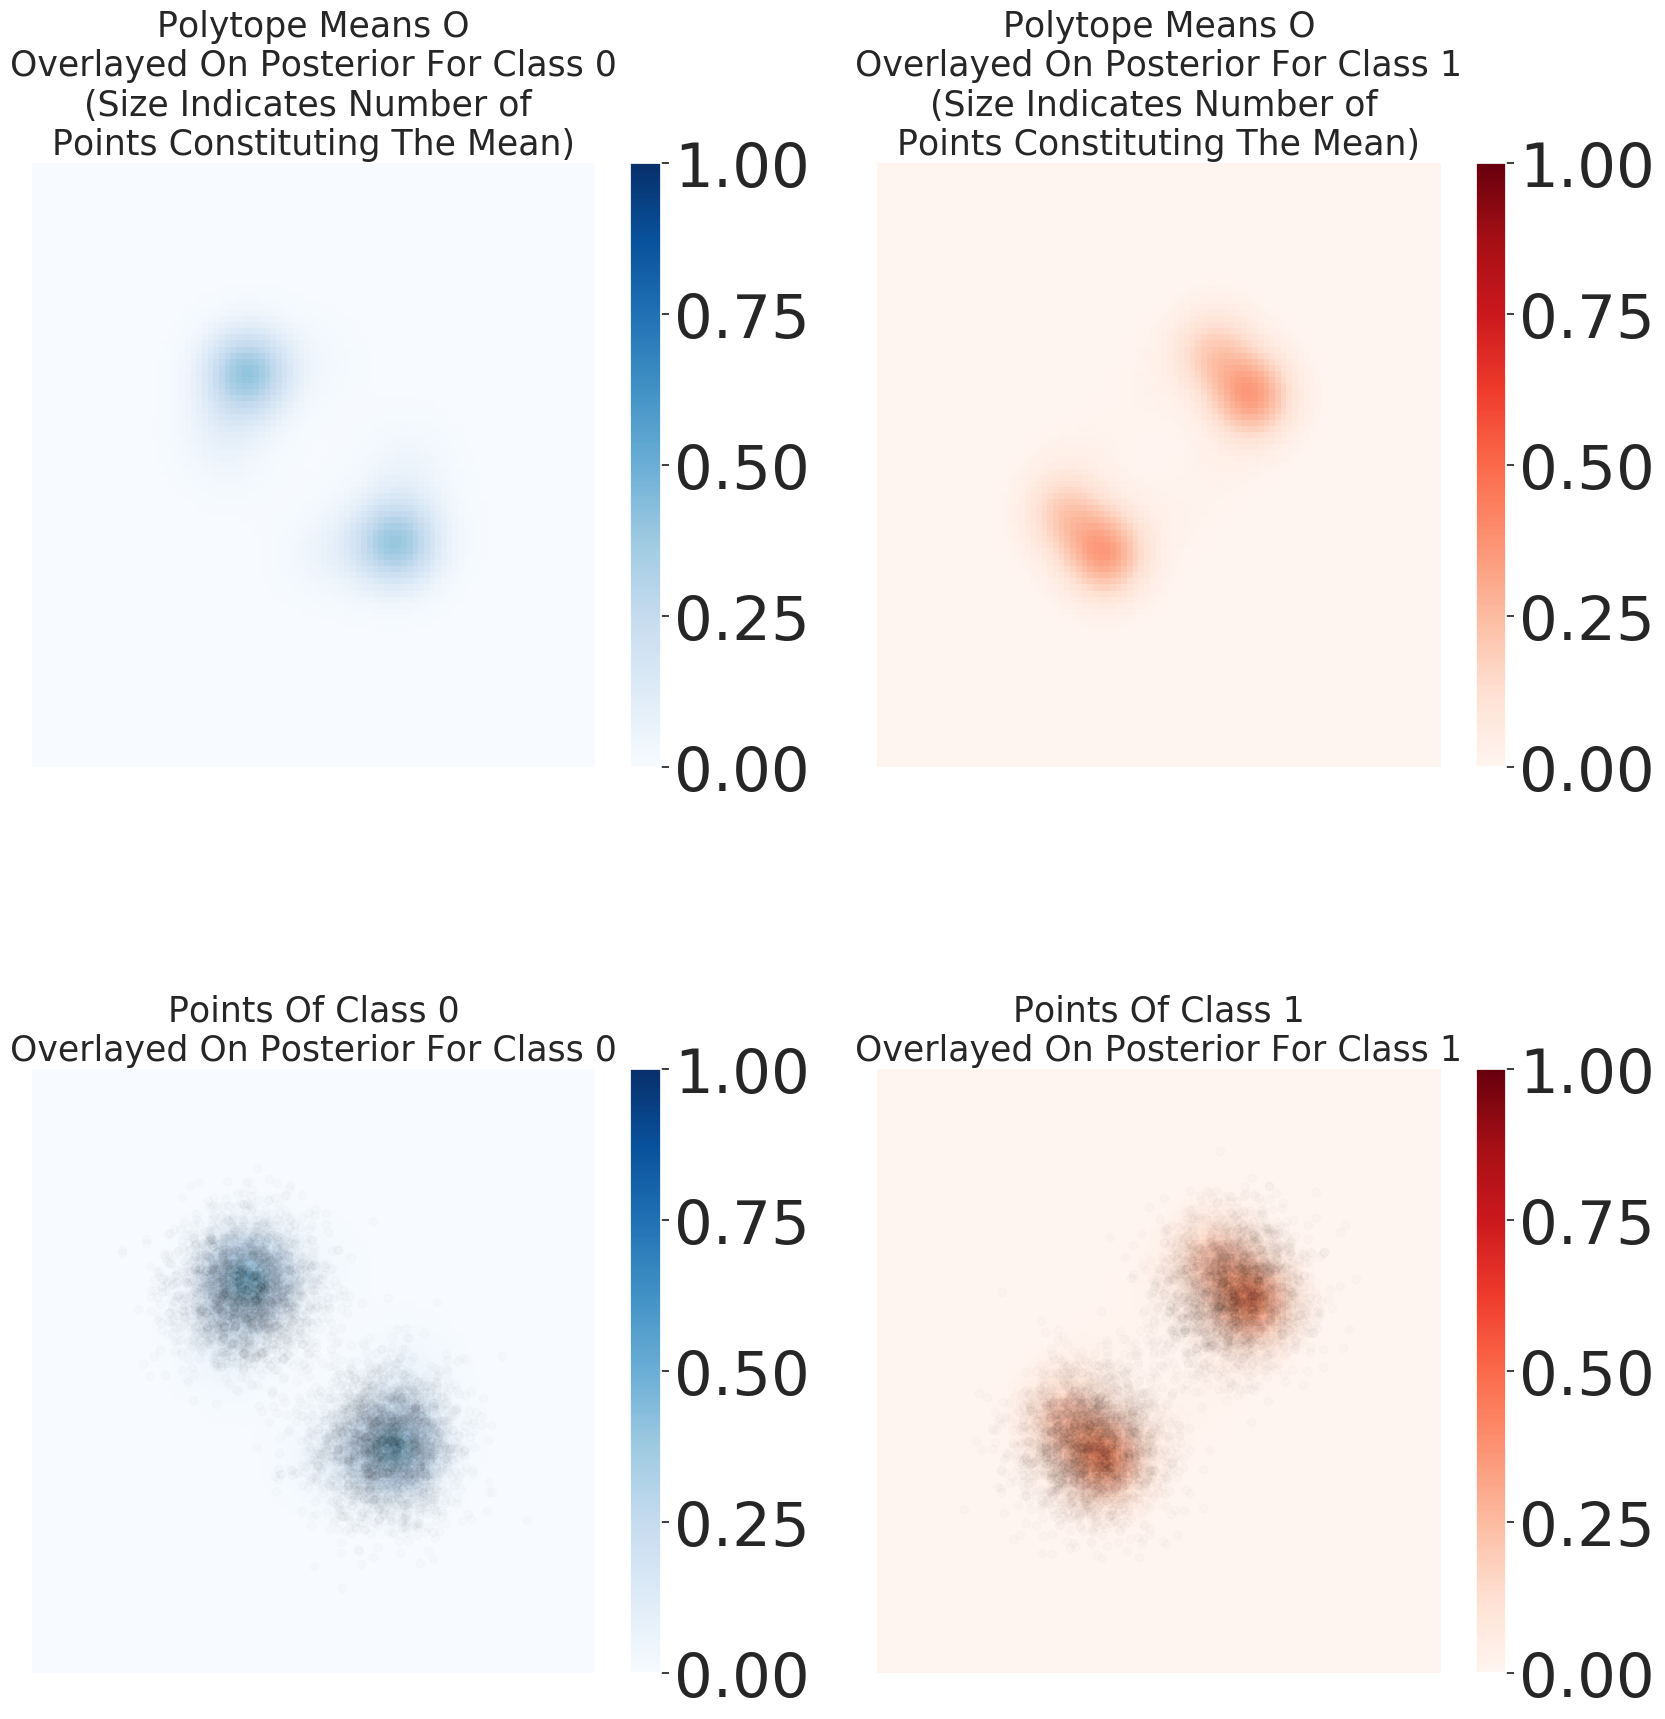

In [269]:
figs, axs = plt.subplots(2, 2, figsize = (20, 20))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
    
#instantiate the posterior predictions
y_proba_neural_KDE_grid = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), 2))
y_proba = neural_KDG.predict_proba(np.c_[xx.ravel(), yy.ravel()], pooling = "class")

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(2):
    indices_of_y_val = np.where(neural_KDG.polytope_means_y == y_val)
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_neural_KDE_grid[:, y_val] = y_proba[:, y_val]

    for i in range(2):
        figs.colorbar(axs[i][y_val].pcolormesh(xx, 
               yy,          
               y_proba_neural_KDE_grid[:, y_val].reshape(xx.shape),
               cmap = "Reds" if y_val == 1 else "Blues", vmin = 0, vmax = 1),
                 ax = axs[i][y_val])
    
    axs[0][y_val].scatter(np.array(neural_KDG.polytope_means_X)[indices_of_y_val, 0], np.array(neural_KDG.polytope_means_X)[indices_of_y_val, 1], c = 2 * np.array(neural_KDG.polytope_means_y)[indices_of_y_val] - 1, s = 500 * np.array(neural_KDG.polytope_means_weight) / np.max(neural_KDG.polytope_means_weight), edgecolor = 'black', cmap = "seismic")
    axs[0][y_val].set_title("Polytope Means O\nOverlayed On Posterior For Class {}\n(Size Indicates Number of \nPoints Constituting The Mean)".format(y_val), fontsize = 25)
    
for y_val in range(2):
    idxs_of_class = np.where(y_display == y_val)
    axs[1][y_val].set_title("Points Of Class {}\nOverlayed On Posterior For Class {}".format(y_val, y_val), fontsize = 25)
    axs[1][y_val].scatter(X_display[idxs_of_class, 0], X_display[idxs_of_class, 1], c = 'black', alpha = .01)

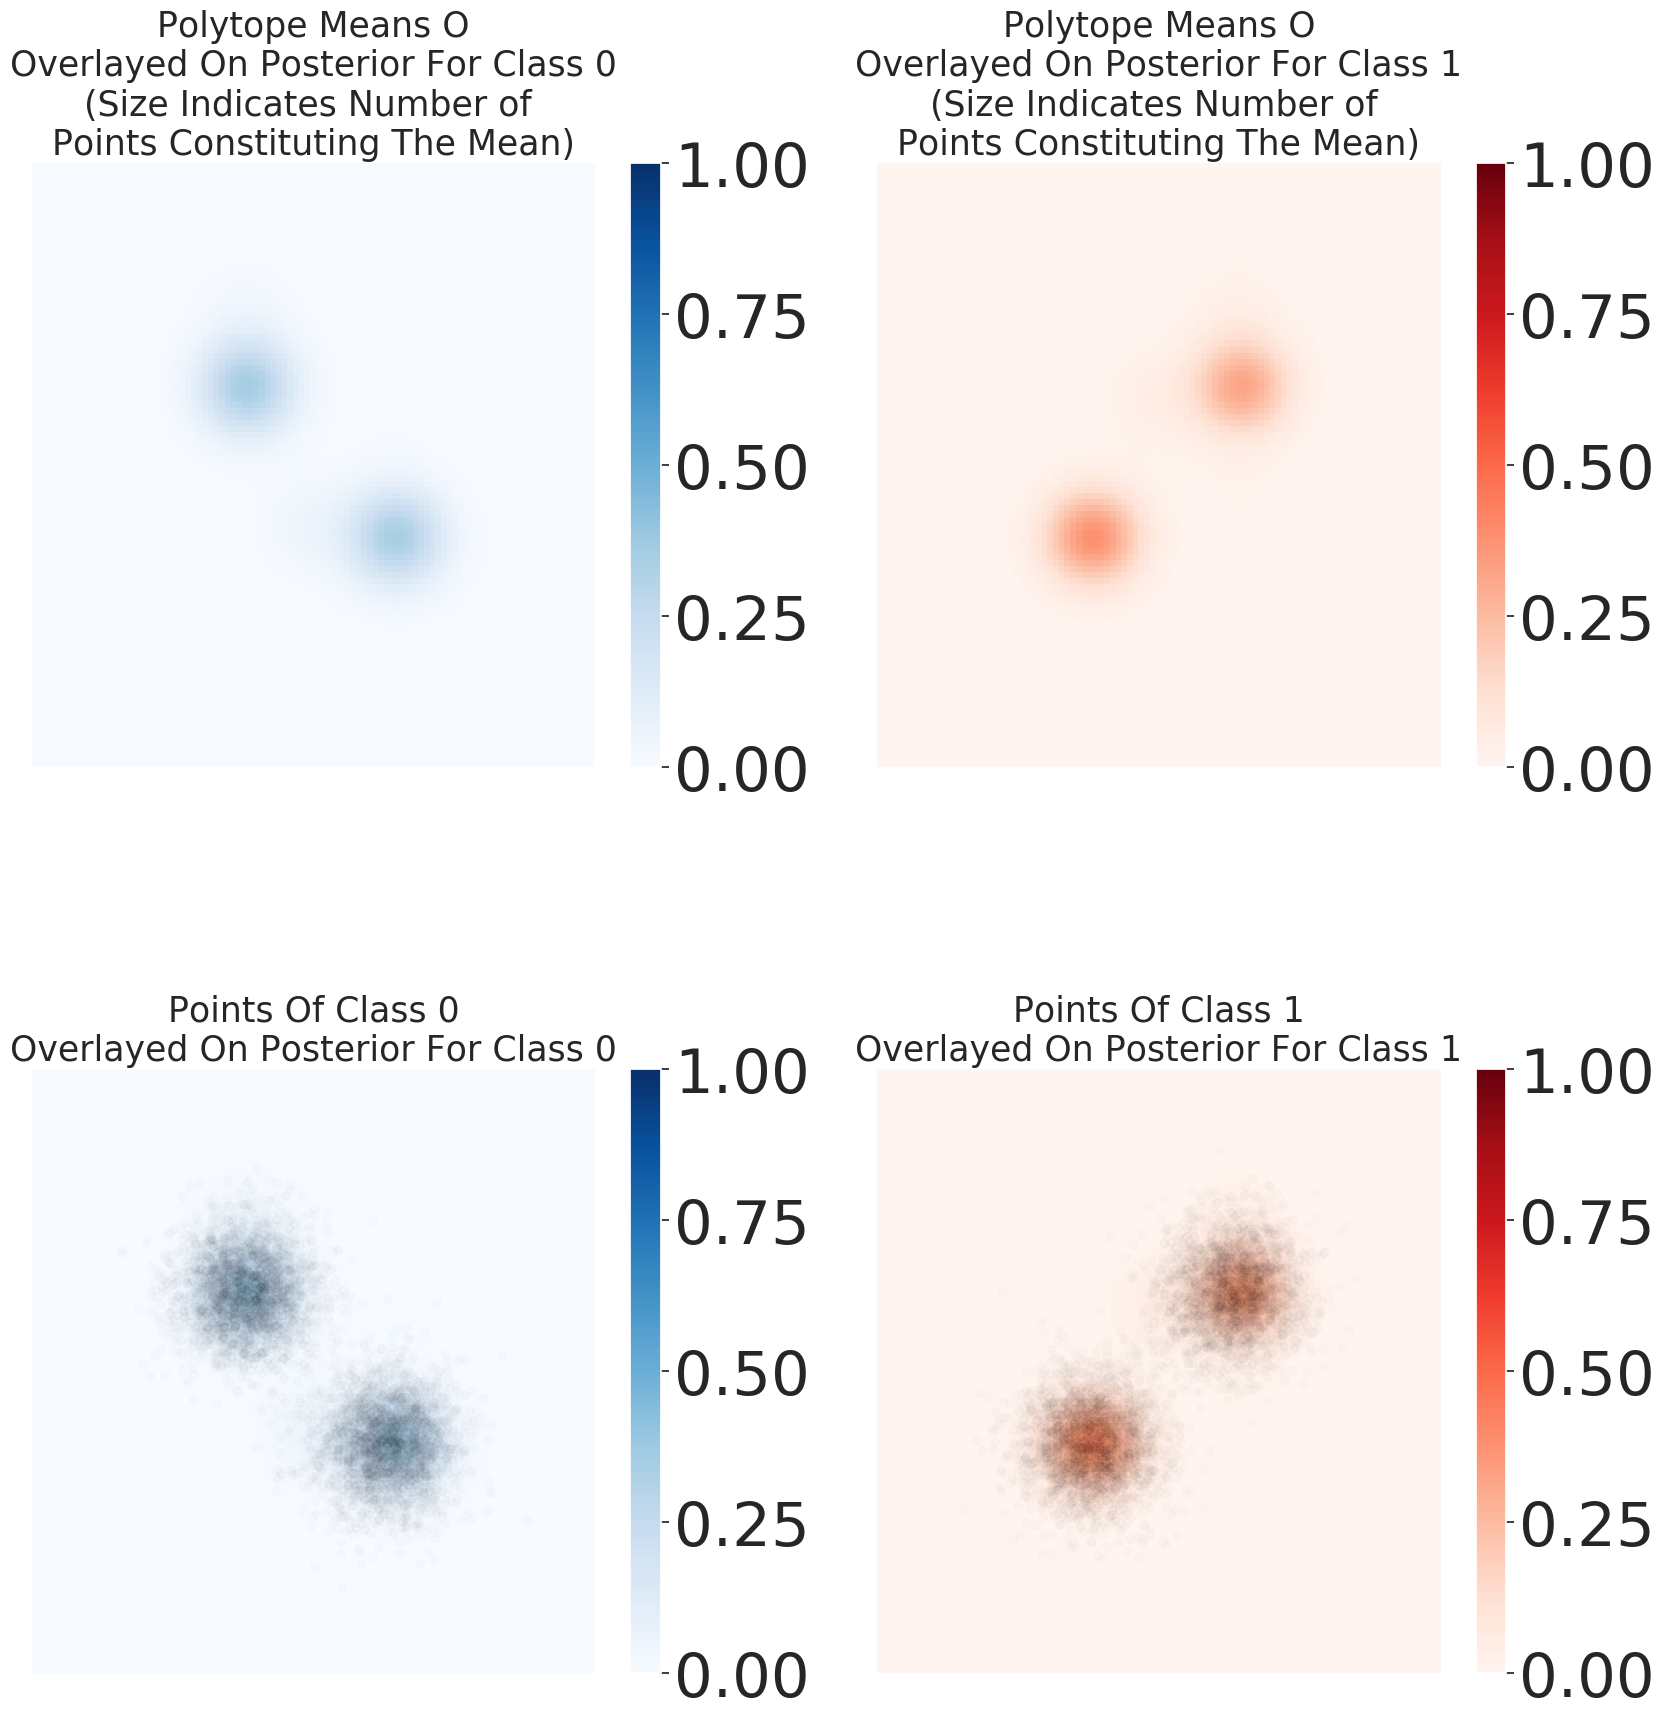

In [270]:
figs, axs = plt.subplots(2, 2, figsize = (20, 20))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 4)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
    
#instantiate the posterior predictions
y_proba_forest_KDE_grid = np.zeros((len(np.c_[xx.ravel(), yy.ravel()]), 2))
y_proba = forest_KDG.predict_proba(np.c_[xx.ravel(), yy.ravel()], pooling = "class")

#loops over the KDEs (and thus, implicitly, the y-values)
for y_val in range(2):
    indices_of_y_val = np.where(forest_KDG.polytope_means_y == y_val)
    #compute the (unnormalized) posterior for the KDE corresponding
    #to y_val. NOTE: we perform np.exp since the score_samples 
    #function returns the log of the probability of belonging to that 
    #class, so we must invert the log through an exponential
    y_proba_forest_KDE_grid[:, y_val] = y_proba[:, y_val]

    for i in range(2):
        figs.colorbar(axs[i][y_val].pcolormesh(xx, 
               yy,          
               y_proba_forest_KDE_grid[:, y_val].reshape(xx.shape),
               cmap = "Reds" if y_val == 1 else "Blues", vmin = 0, vmax = 1),
                 ax = axs[i][y_val])
    
    axs[0][y_val].scatter(np.array(forest_KDG.polytope_means_X)[indices_of_y_val, 0], np.array(forest_KDG.polytope_means_X)[indices_of_y_val, 1], c = 2 * np.array(forest_KDG.polytope_means_y)[indices_of_y_val] - 1, s = 500 * np.array(forest_KDG.polytope_means_weight) / np.max(forest_KDG.polytope_means_weight), edgecolor = 'black', cmap = "seismic")
    axs[0][y_val].set_title("Polytope Means O\nOverlayed On Posterior For Class {}\n(Size Indicates Number of \nPoints Constituting The Mean)".format(y_val), fontsize = 25)
    
for y_val in range(2):
    idxs_of_class = np.where(y_display == y_val)
    axs[1][y_val].set_title("Points Of Class {}\nOverlayed On Posterior For Class {}".format(y_val, y_val), fontsize = 25)
    axs[1][y_val].scatter(X_display[idxs_of_class, 0], X_display[idxs_of_class, 1], c = 'black', alpha = .01)

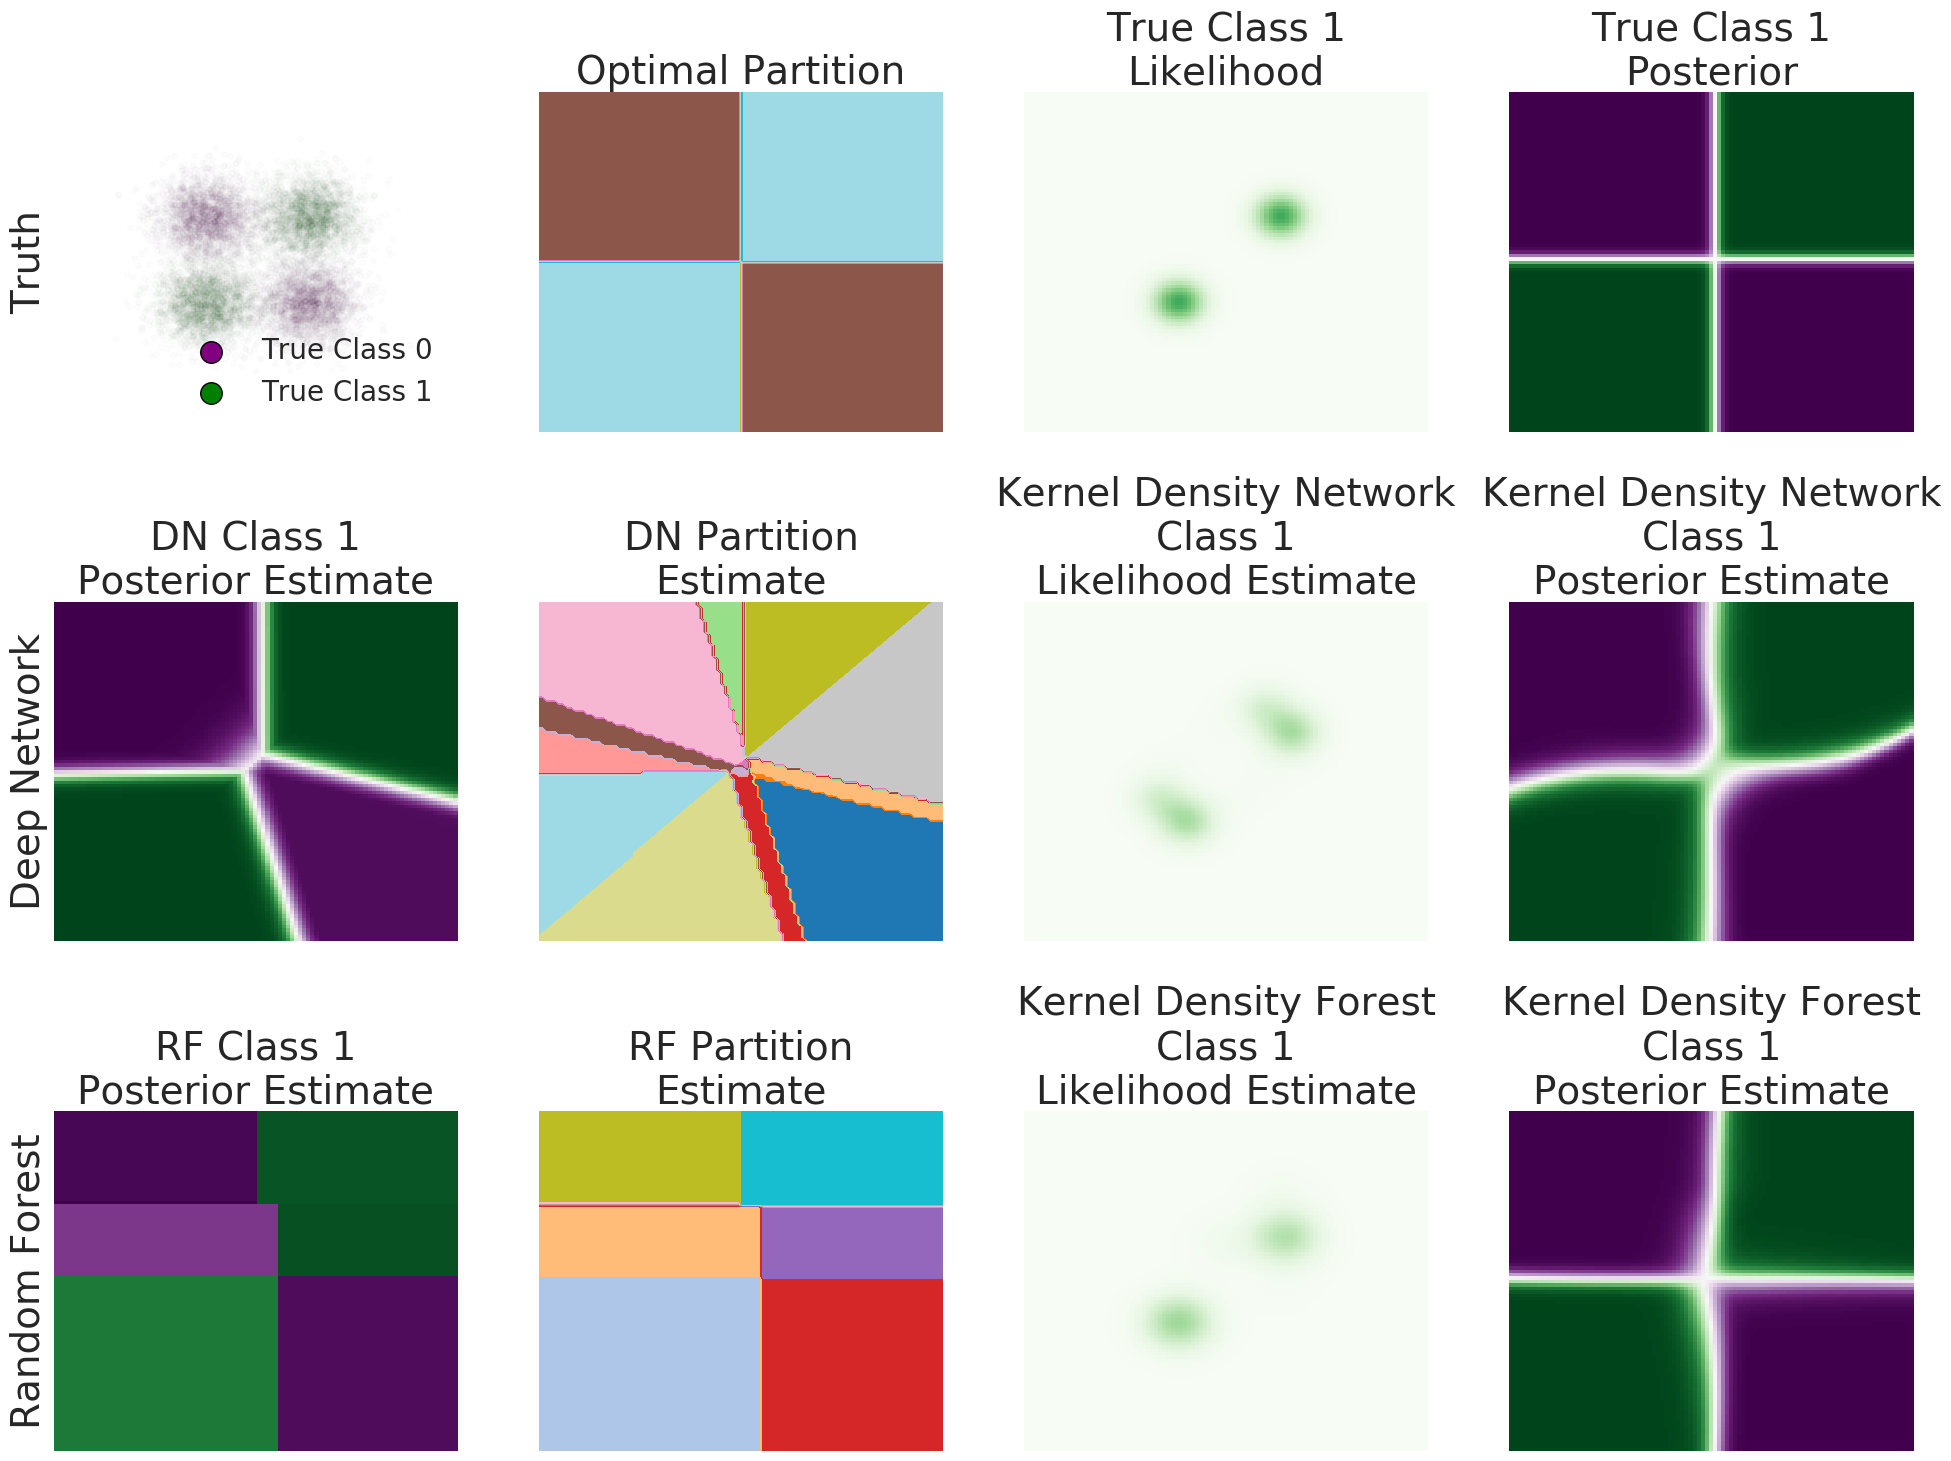

In [271]:
figs, axs = plt.subplots(3, 4, figsize = (6 * 4, 6 * 3))
plt.subplots_adjust(hspace=0.5)
sns.set(font_scale = 2.5)
figs.text(0.5, 0.04, '', ha='center')
figs.set_facecolor('white')

for i, ax in enumerate(axs.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.label_outer()
    ax.set_facecolor('white')
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)
        
for i in range(3):
    axs[i][0].set_ylim((np.min(yy), np.max(yy)))
    axs[i][0].set_xlim((np.min(xx), np.max(xx)))
        
# Plot the training points
axs[0][0].scatter(X_display[np.where(y_display == 0)[0], 0], X_display[np.where(y_display == 0)[0], 1], c='purple', label = "True Class 0",
          s=15, edgecolor = 'black', alpha = .01)
axs[0][0].scatter(X_display[np.where(y_display == 1)[0], 0], X_display[np.where(y_display == 1)[0], 1], c='green', label = "True Class 1",
          s=15, edgecolor = 'black', alpha = .01)
leg = axs[0][0].legend(prop={'size': 20}, markerscale=4, loc = "lower right", frameon = False)
axs[0][0].set_ylabel("Truth", fontsize = 28)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

axs[0][1].set_title("Optimal Partition", fontsize = 28)
c = np.array([int(np.sign(np.prod(ra)) == 1) for ra in np.c_[xx.ravel(), yy.ravel()]])
#c = np.array([np.sum((ra > 0).astype('int') * 2 ** np.arange(0, len(ra))) for ra in np.c_[xx.ravel(), yy.ravel()]])
axs[0][1].contourf(xx, yy, c.reshape(xx.shape), cmap = "tab20", vmin = -1, vmax = 1)

axs[0][2].set_title("True Class 1\nLikelihood", fontsize = 28)
axs[0][2].pcolormesh(xx, 
                               yy, 
                               true_posterior[:, 0].reshape(xx.shape), 
                               cmap="Greens", 
                               vmin = 0, 
                               vmax = 1)

axs[0][3].set_title("True Class 1\nPosterior", fontsize = 28)
axs[0][3].pcolormesh(xx, 
                               yy, 
                               (true_posterior[:, 0] / np.sum(true_posterior, axis = 1)).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[1][0].set_title("DN Class 1\nPosterior Estimate", fontsize = 28)
axs[1][0].set_ylabel("Deep Network", fontsize = 28)

estimated_class_1_posterior = network.predict(np.c_[xx.ravel(), yy.ravel()])
axs[1][0].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[1][1].contourf(xx, yy, polytope_ids.reshape(xx.shape), cmap = "tab20", levels = len(np.unique(polytope_ids)))
axs[1][1].set_title("DN Partition\nEstimate", fontsize = 28)

axs[1][2].set_title("Kernel Density Network\nClass 1\nLikelihood Estimate", fontsize = 28)
axs[1][2].pcolormesh(xx, 
                               yy, 
                               y_proba_neural_KDE_grid[:, 1].reshape(xx.shape), 
                               cmap="Greens", 
                               vmin = 0, 
                               vmax = 1)
axs[1][3].set_title("Kernel Density Network\nClass 1\nPosterior Estimate", fontsize = 28)
axs[1][3].pcolormesh(xx, 
                               yy, 
                               (y_proba_neural_KDE_grid[:, 1] / np.sum(y_proba_neural_KDE_grid, axis = 1)).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

axs[2][0].set_title("RF Class 1\nPosterior Estimate", fontsize = 28)
axs[2][0].set_ylabel("Random Forest", fontsize = 28)

estimated_class_1_posterior = rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
axs[2][0].pcolormesh(xx, 
                               yy, 
                               estimated_class_1_posterior.reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)

predicted_leaf_ids_across_trees = np.array([keras.utils.to_categorical(np.unique(tree.apply(np.c_[xx.ravel(), yy.ravel()]), return_inverse = True)[1], num_classes = 2 ** (width + 1)) for tree_idx, tree in enumerate(rfc.estimators_)])
length = np.shape(predicted_leaf_ids_across_trees)[-1]
partition_ids = np.matmul(predicted_leaf_ids_across_trees[0], np.expand_dims(np.logspace(0, length, num = length, base = 2), axis = 1))# + np.matmul(predicted_leaf_ids_across_trees[1], np.expand_dims(np.logspace(length, 2*length, num = length, base = 2), axis = 1))
_, partition_ids = np.unique(partition_ids, return_inverse = True)

axs[2][1].contourf(xx, yy, partition_ids.reshape(xx.shape), cmap = "tab20", levels = len(np.unique(partition_ids)))
axs[2][1].set_title("RF Partition\nEstimate", fontsize = 28)

axs[2][2].set_title("Kernel Density Forest\nClass 1\nLikelihood Estimate", fontsize = 28)
axs[2][2].pcolormesh(xx, 
                               yy, 
                               y_proba_forest_KDE_grid[:, 1].reshape(xx.shape), 
                               cmap="Greens", 
                               vmin = 0, 
                               vmax = 1)

axs[2][3].set_title("Kernel Density Forest\nClass 1\nPosterior Estimate", fontsize = 28)
axs[2][3].pcolormesh(xx, 
                               yy, 
                               (y_proba_forest_KDE_grid[:, 1] / np.sum(y_proba_forest_KDE_grid, axis = 1)).reshape(xx.shape), 
                               cmap="PRGn", 
                               vmin = 0, 
                               vmax = 1)